In [1]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import play_song as song
import feature_selection as fs

In [2]:
## Load and temp PREPROC

In [3]:
df = pd.read_csv('./project_data/out_eda1.csv', 
                 index_col = 'Claim Identifier')

In [4]:
df = df.dropna()

In [5]:
label_mapping = {
    "1. CANCELLED": 1,
    "2. NON-COMP": 2,
    "3. MED ONLY": 3,
    "4. TEMPORARY": 4,
    "5. PPD SCH LOSS": 5,
    "6. PPD NSL": 6,
    "7. PTD": 7,
    "8. DEATH": 8
}

df['Claim Injury Type'] = df['Claim Injury Type'].replace(label_mapping)

In [6]:
# Example usage in evaluate_features function:
X, y = df.drop(columns=['Claim Injury Type']), df['Claim Injury Type']

In [7]:
num = ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents',
       'Accident Year', 'Accident Month', 'Accident Day', 'Assembly Year', 'Assembly Month', 'Assembly Day',
       'C-2 Year', 'C-2 Month', 'C-2 Day', 'First Hearing Year']

categ = ['Alternative Dispute Resolution', 'Attorney/Representative', 'Carrier Name', 'Carrier Type',
         'County of Injury', 'COVID-19 Indicator', 'District Name', 'Gender',
         'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
         'WCIO Part Of Body Code', 'Zip Code', 'C-3 Date Binary' ]

In [8]:
## EVAL function

In [9]:
def evaluate_features(df, num, categ, 
                      rfe_features, rfe_model, k=5):
    
    
    X, y = df.drop(columns=['Claim Injury Type']), df['Claim Injury Type']
    kf = KFold(n_splits=k)
    selected_features = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Numerical
        print('----LASSO----')
        lasso = fs.lasso(X_train, y_train, num)
        print('----RFE----')
        # for model in rfe_model: ## FUTURE
        rfe = fs.rfe(X_train, y_train, num, rfe_features, rfe_model)
        print('----CORR----')
        corr = fs.correlation_matrix(X_train, num)
        #print('----VAR----')
        var = fs.var(X_train, num)
        
        # Categorical
        print('----CHI2----')
        chi2 = fs.chi_squared(X_train, y_train, categ)
        print('----MI----')
        mutual_information = fs.mutual_information(X_train, y_train, categ)
        
        
        # Combine selected features from each method
        num_selected = set(lasso).union(rfe, corr, var)
        categ_selected = set(chi2).union(mutual_information)

        # Filter training and validation sets based on selected features
        print(num_selected)
        print(categ_selected)
        
        song.play_('audio.mp3')
        
        # Train model and record performance
        model = LogisticRegression()
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_val_selected)
        score = accuracy_score(y_val, y_pred)
        
        # Save selected features
        features = X.columns[selector.get_support()]
        selected_features.append(features)

    
    # Count occurrences of each feature across folds
    feature_counts = Counter(np.concatenate(selected_features))
    
    # Select only features that appear in all folds
    final_features = [feature for feature, count in feature_counts.items() if count == k]
    return final_features




----LASSO----


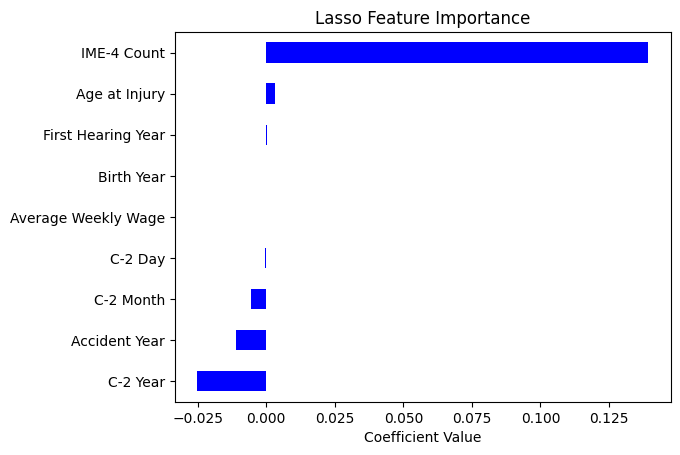

----RFE----
Trying with 12 features: 12 selected features.
Classification Report for 12 features:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      2130
           2       0.83      1.00      0.91    120829
           3       0.17      0.02      0.03     31228
           4       0.67      0.90      0.77     60551
           5       0.20      0.00      0.00     14513
           6       0.00      0.00      0.00       928
           7       0.00      0.00      0.00        13
           8       0.00      0.00      0.00        99

    accuracy                           0.76    230291
   macro avg       0.23      0.24      0.21    230291
weighted avg       0.65      0.76      0.68    230291

Trying with 13 features: 13 selected features.
Classification Report for 13 features:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      2130
           2       0.83      1.00      0.91    120829
  

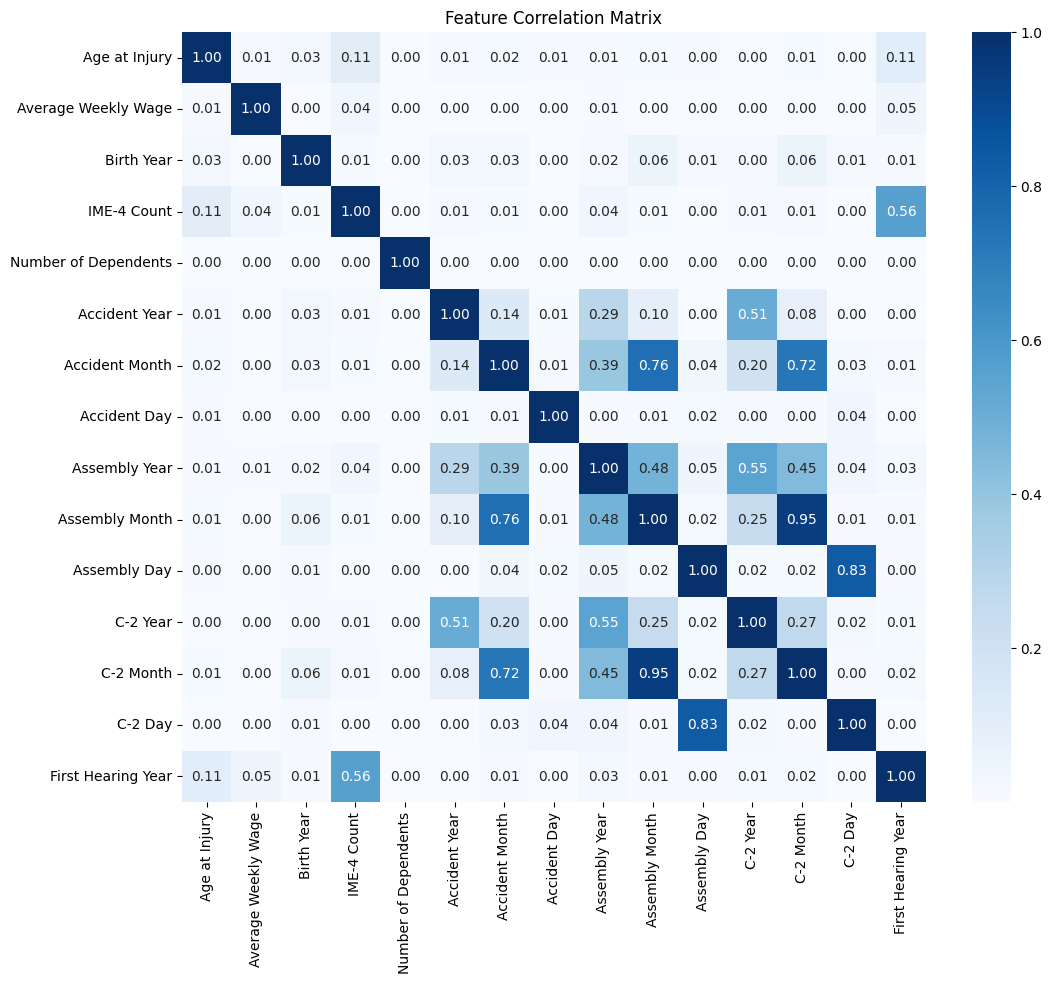

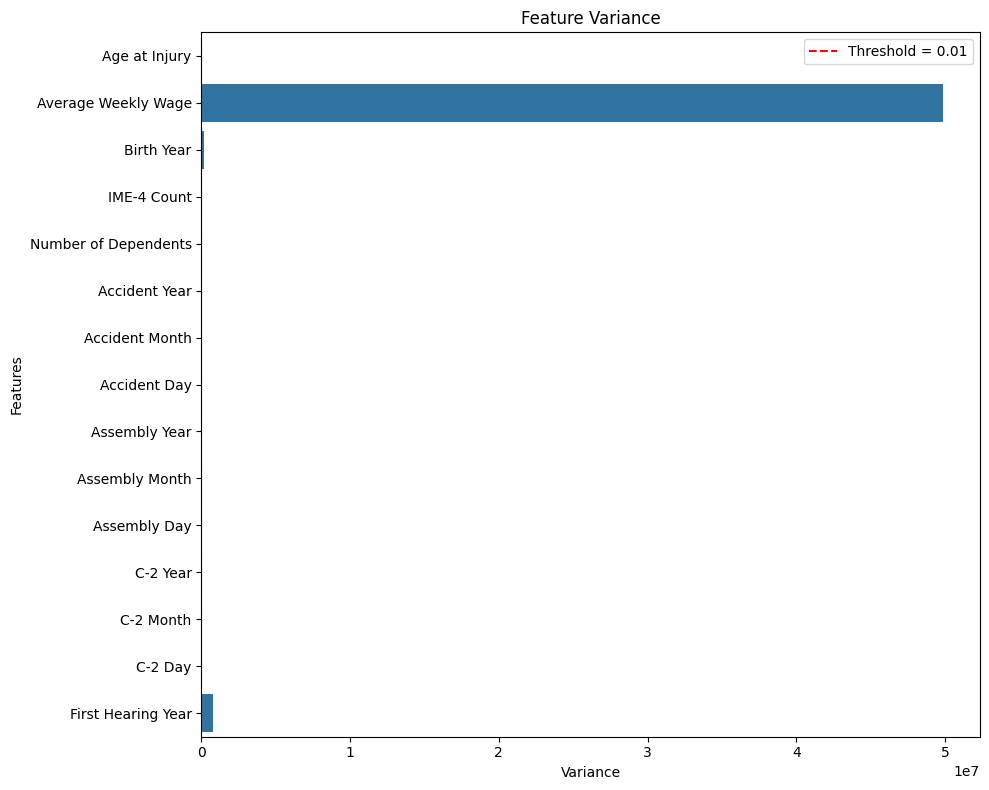

----CHI2----


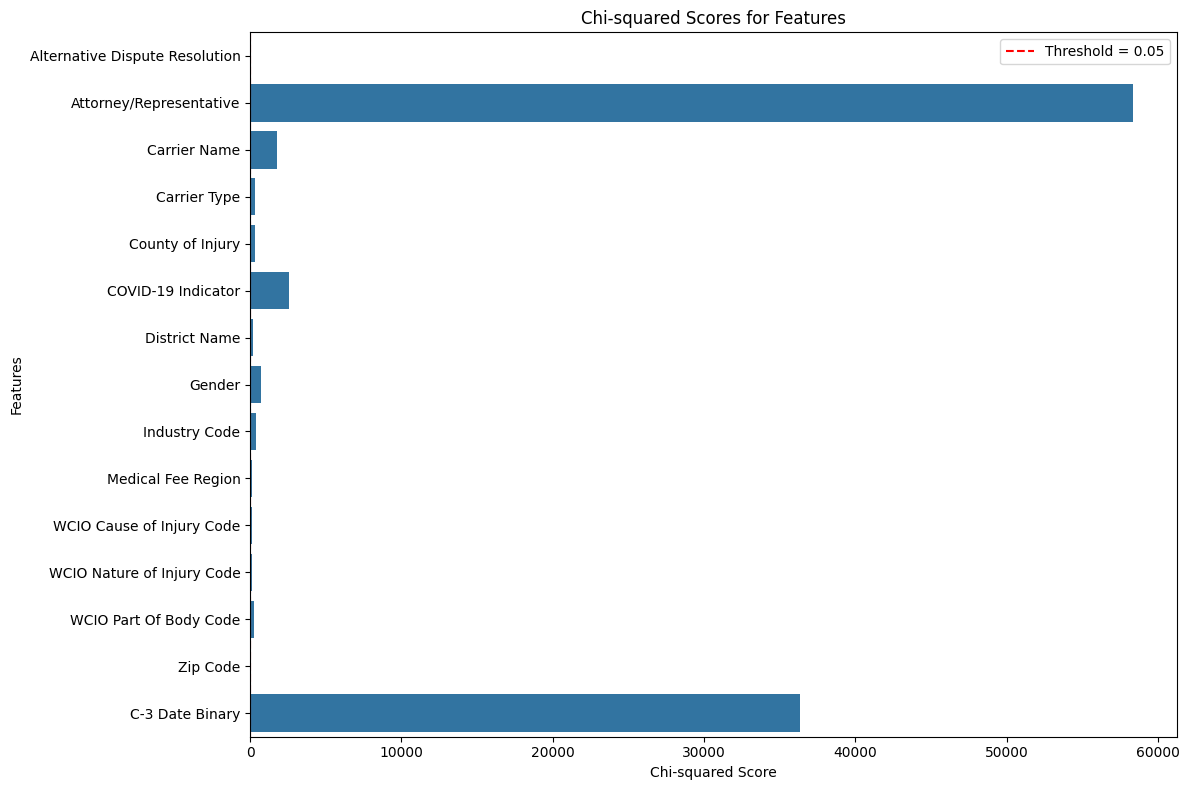

----MI----


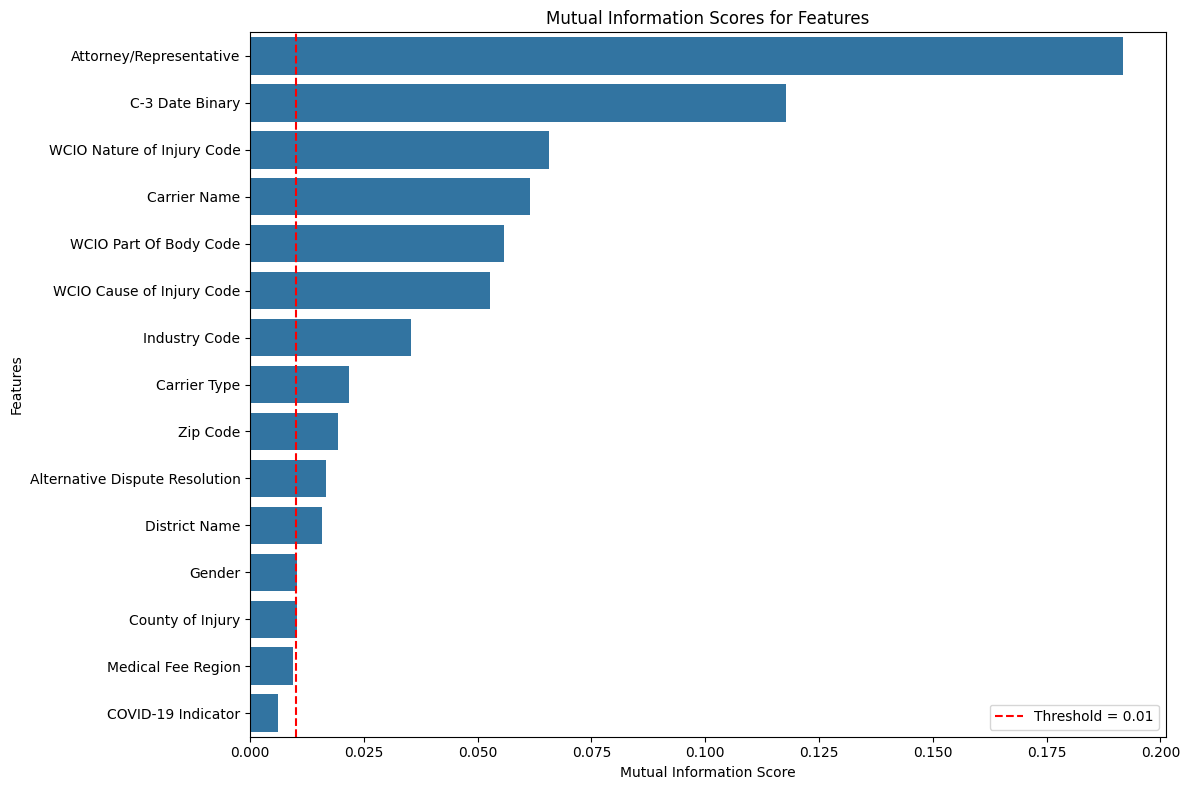

{'IME-4 Count', 'Accident Year', 12, 13, 14, 15, 'First Hearing Year', 'Average Weekly Wage', 'Number of Dependents', 'C-2 Month', 'Assembly Day', 'Birth Year', 'Accident Day', 'C-2 Day', 'Age at Injury', 'Assembly Year', 'C-2 Year', 'Assembly Month', 'Accident Month'}
{'District Name', 'Carrier Type', 'Carrier Name', 'COVID-19 Indicator', 'WCIO Nature of Injury Code', 'Industry Code', 'Medical Fee Region', 'County of Injury', 'Attorney/Representative', 'WCIO Cause of Injury Code', 'Alternative Dispute Resolution', 'WCIO Part Of Body Code', 'Gender', 'Zip Code', 'C-3 Date Binary'}


Input #0, wav, from '/var/folders/mm/fxsq_1490x9dd2w76tqvt3kr0000gn/T/tmpig5hcvqp.wav':
  Duration: 00:00:10.00, bitrate: 1536 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, 2 channels, s16, 1536 kb/s


NameError: name 'X_train_selected' is not defined

In [10]:
rfe_features = [12, 13, 14, 15]

evaluate_features(df, num, categ, 
                  rfe_features = rfe_features,
                  rfe_model = LogisticRegression(),
                  k = 2)

### output

{'IME-4 Count', 'Accident Year', 12, 13, 14, 15, 'First Hearing Year', 'Average Weekly Wage', 'Number of Dependents', 'C-2 Month', 'Assembly Day', 'Birth Year', 'Accident Day', 'C-2 Day', 'Age at Injury', 'Assembly Year', 'C-2 Year', 'Assembly Month', 'Accident Month'}
{'District Name', 'Carrier Type', 'Carrier Name', 'COVID-19 Indicator', 'WCIO Nature of Injury Code', 'Industry Code', 'Medical Fee Region', 'County of Injury', 'Attorney/Representative', 'WCIO Cause of Injury Code', 'Alternative Dispute Resolution', 'WCIO Part Of Body Code', 'Gender', 'Zip Code', 'C-3 Date Binary'}

In [ ]:
song.play_('audio.mp3')

Numerical Features: Lasso, RFE, Variance Threshold, Correlation Matrix, Statistical Tests. <br>
Categorical Features: Chi-Squared Test, Information Gain, Tree-based Methods, Mutual Information.